In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
merged_df = pd.read_csv("merged_data/merged_data.csv")
per_million_df = pd.read_csv("merged_data/merged_per_million.csv")
merged_df_index = pd.read_csv("merged_data/merged_data_index.csv", index_col=0)
per_million_df_index = pd.read_csv("merged_data/merged_per_million_index.csv", index_col=0)


In [74]:
#fill "NaN" with 0
merged_df = merged_df.fillna(0)
per_million_df = per_million_df.fillna(0)
merged_df_index = merged_df_index.fillna(0)
per_million_df_index = per_million_df_index.fillna(0)

##drop per_million and 2023 columns
merged_df = merged_df.drop(columns=["per_million"])
merged_df = merged_df.drop(columns=["2023"])
merged_df_index = merged_df_index.drop(columns=["per_million"])
merged_df_index = merged_df_index.drop(columns=["2023"])

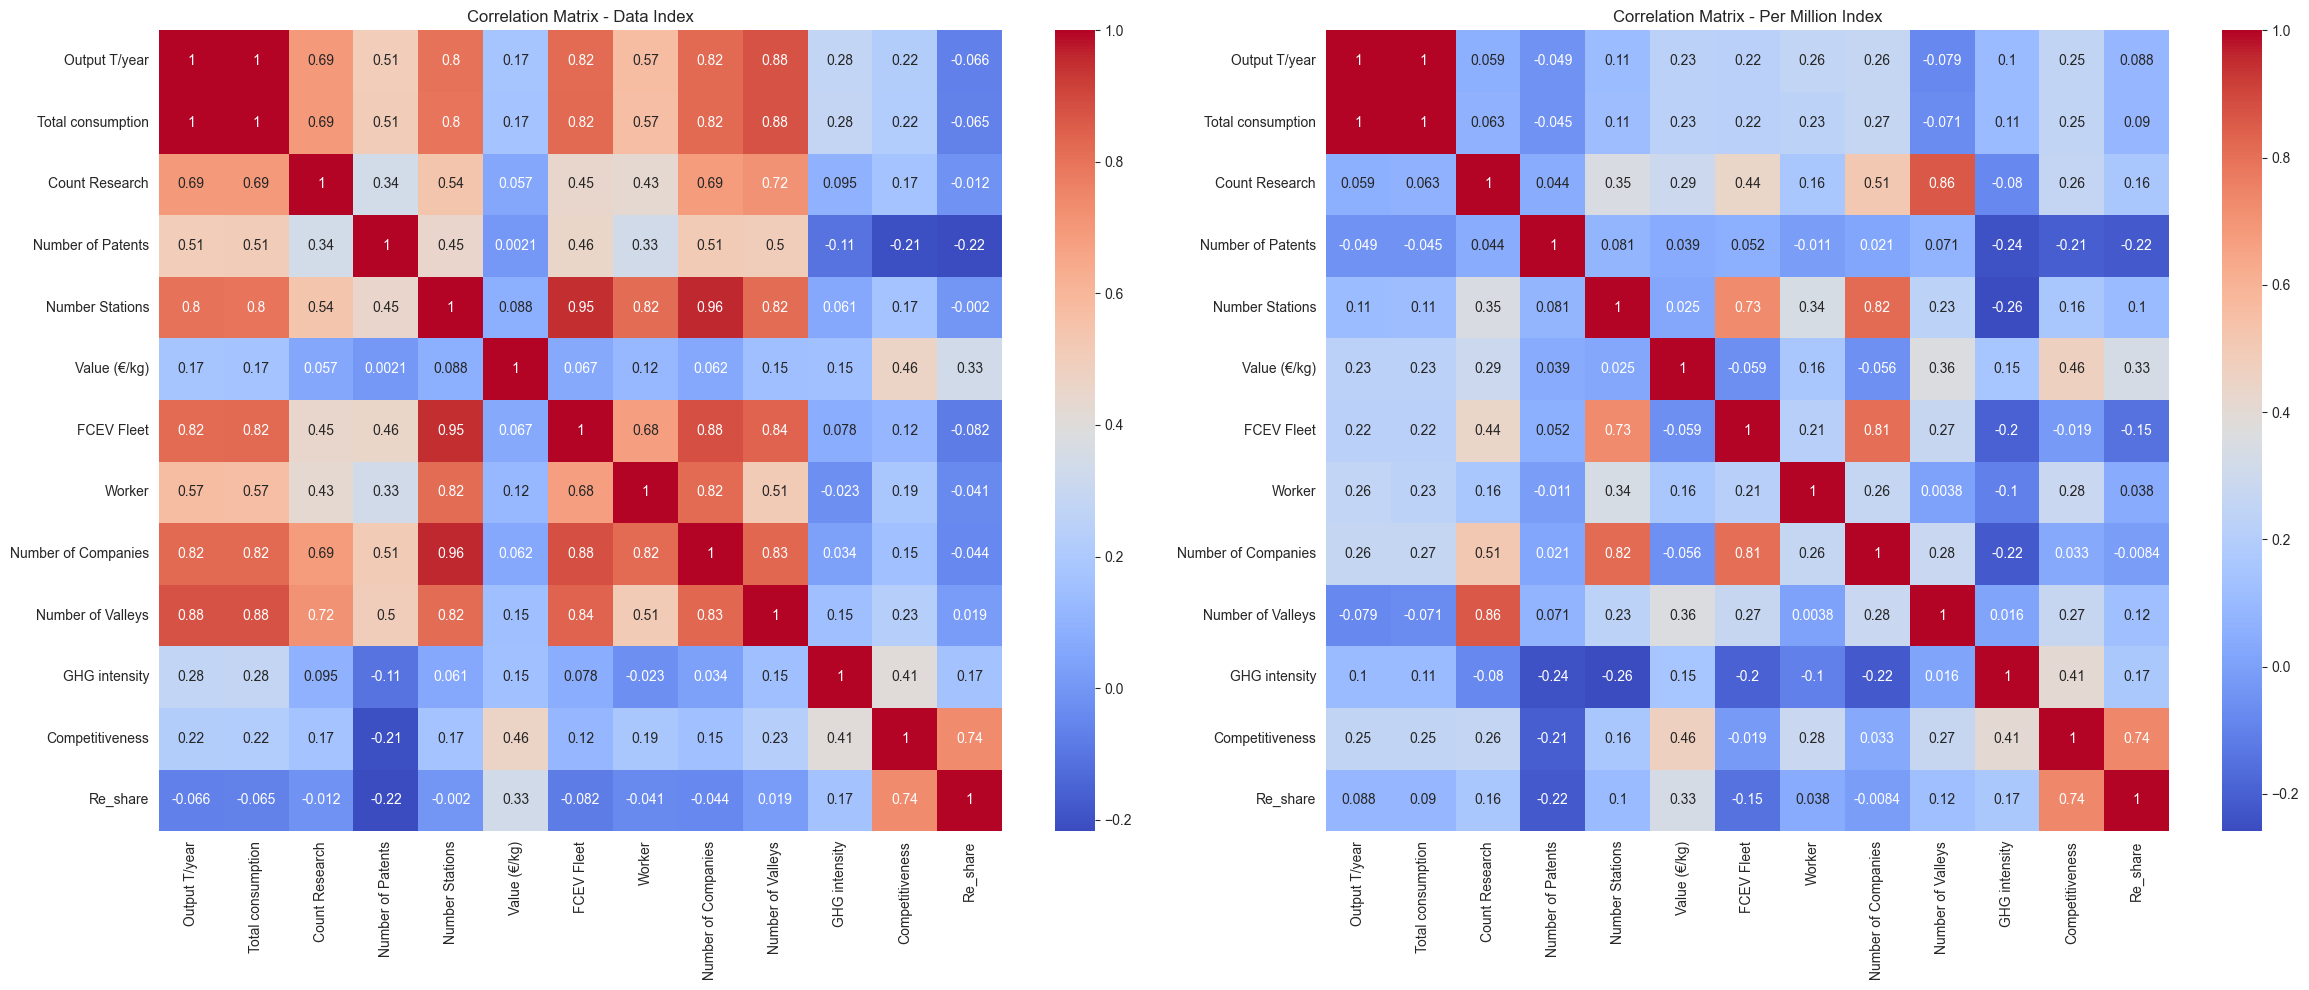

In [85]:
# Exclude non-numeric columns from correlation calculation
numeric_columns = merged_df_index.select_dtypes(include=np.number).columns
correlation_matrix_data_index = merged_df_index[numeric_columns].corr()
correlation_matrix_per_million_index = per_million_df_index[numeric_columns].corr()

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Plot the first heatmap
sns.heatmap(correlation_matrix_data_index, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix - Data Index')

# Plot the second heatmap
sns.heatmap(correlation_matrix_per_million_index, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Matrix - Per Million Index')

# Adjust layout
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('correlation_matrices.png')

# Display the figure
plt.show()

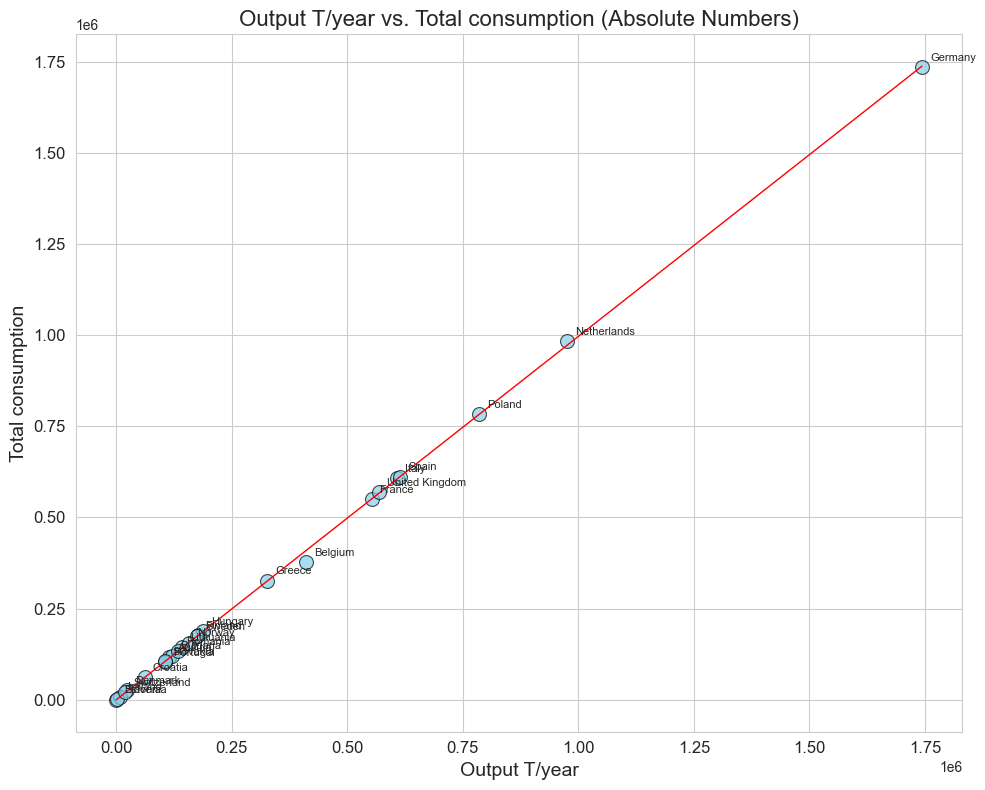

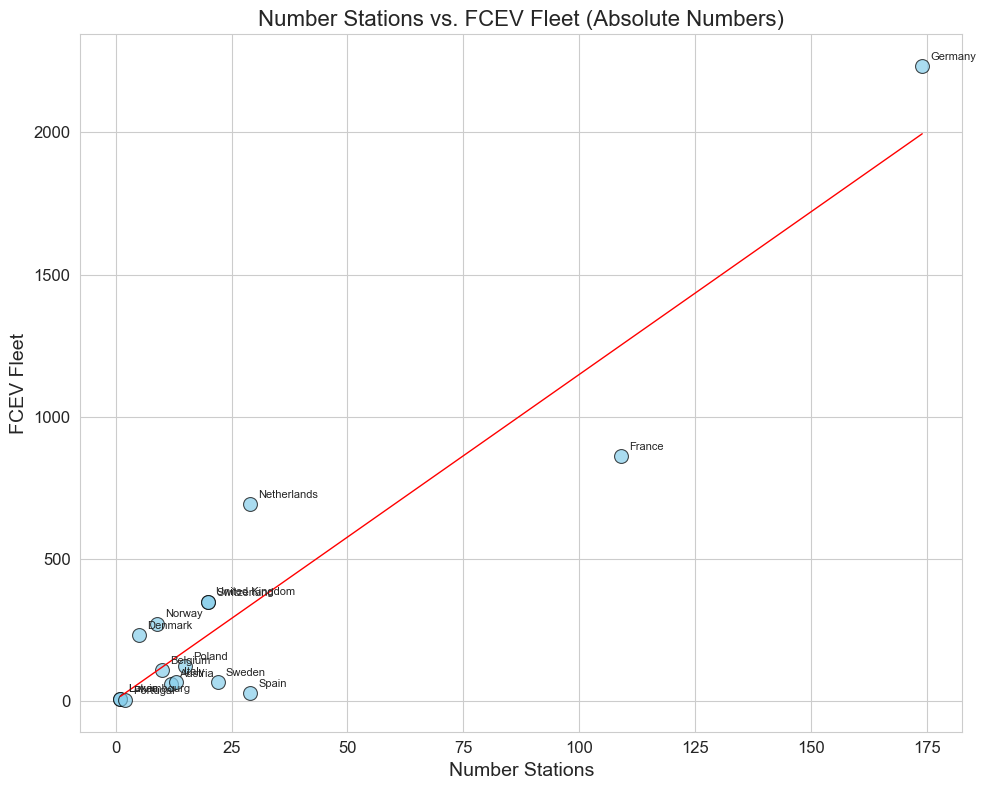

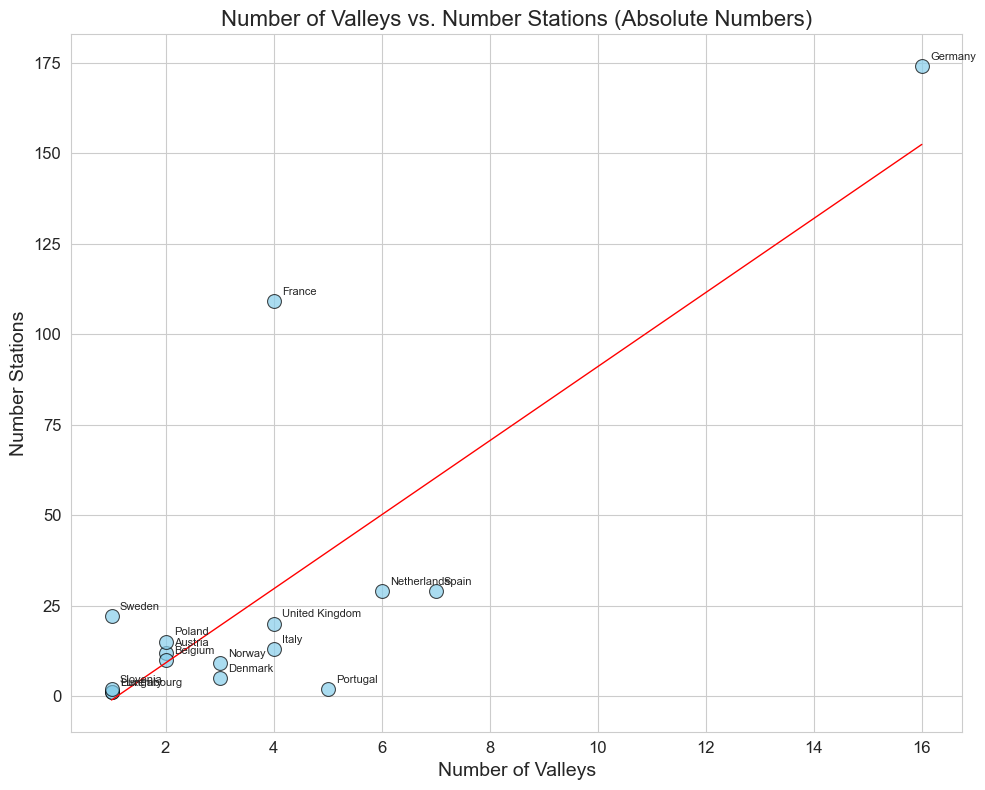

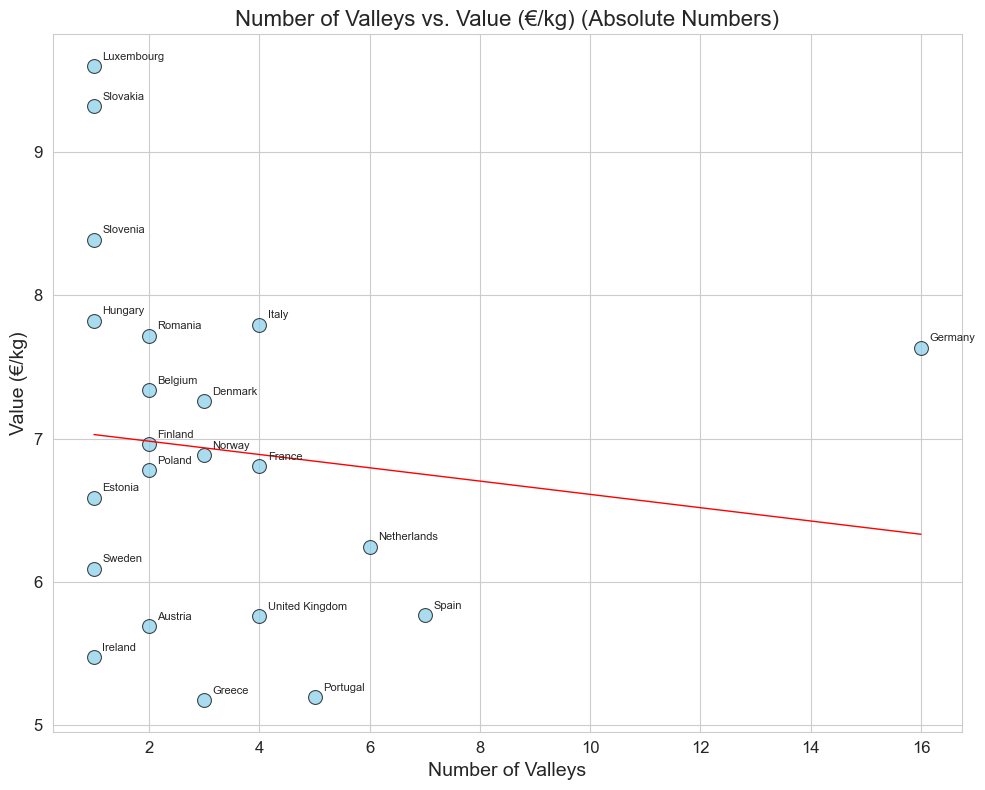

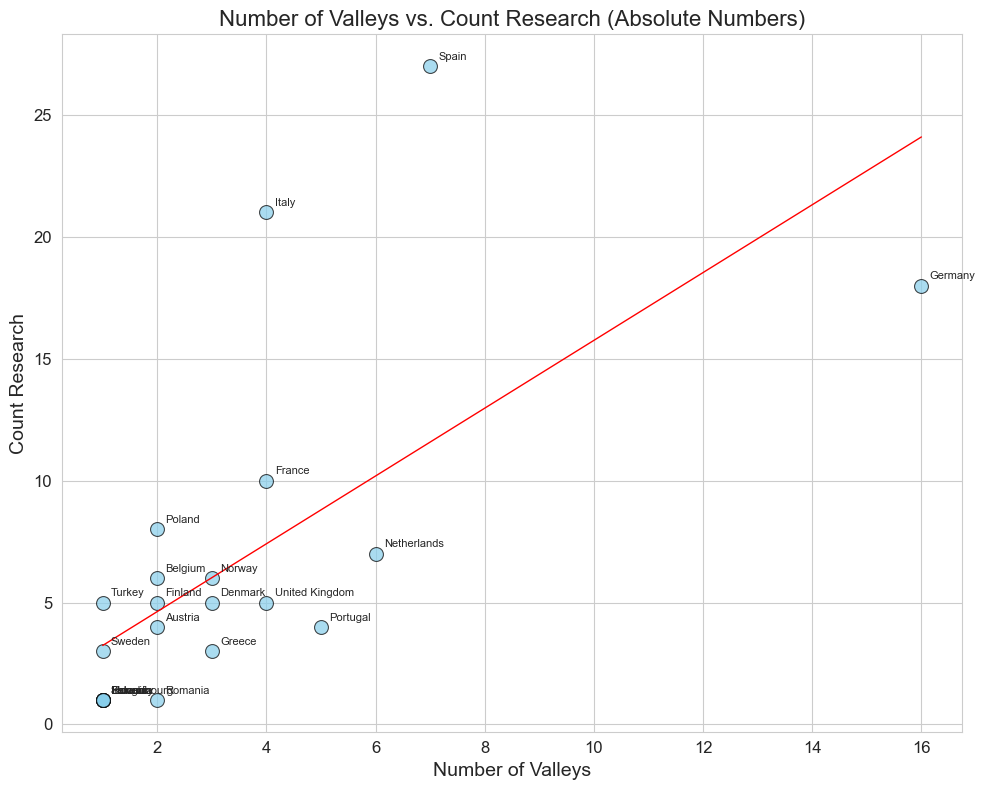

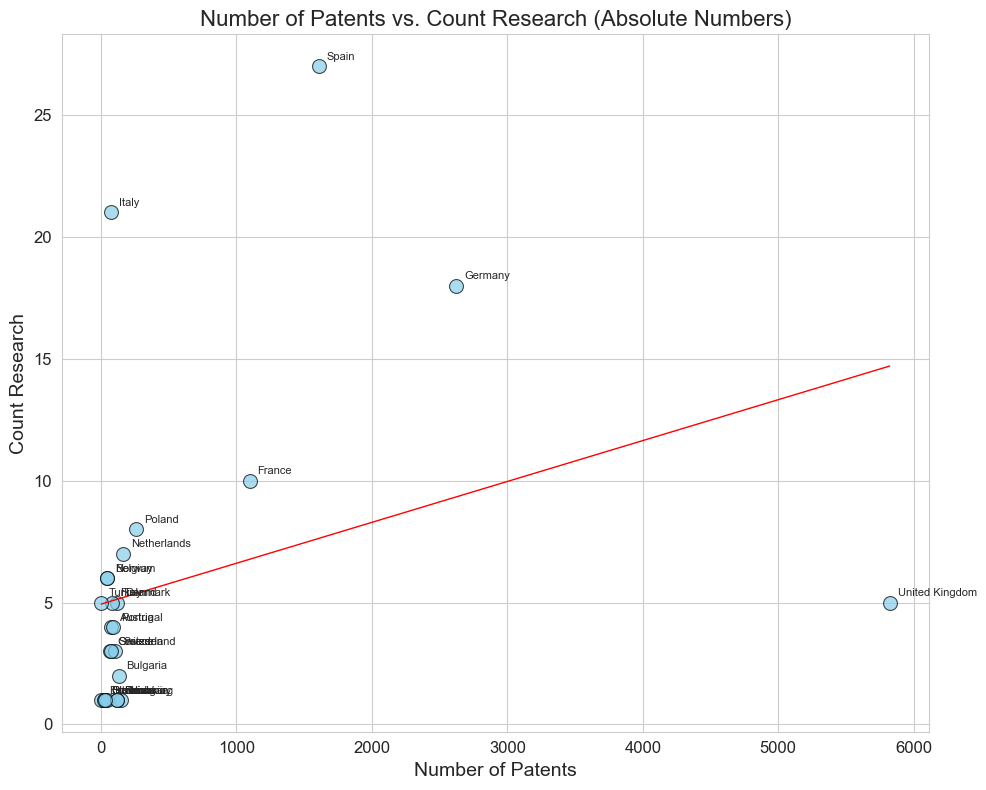

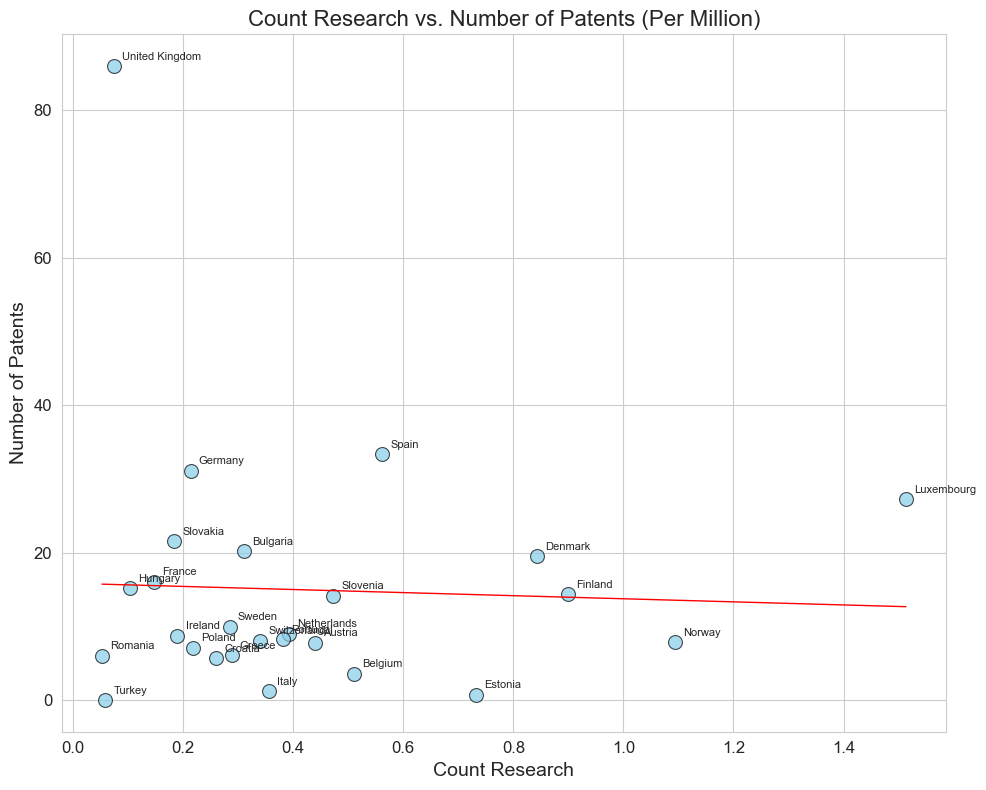

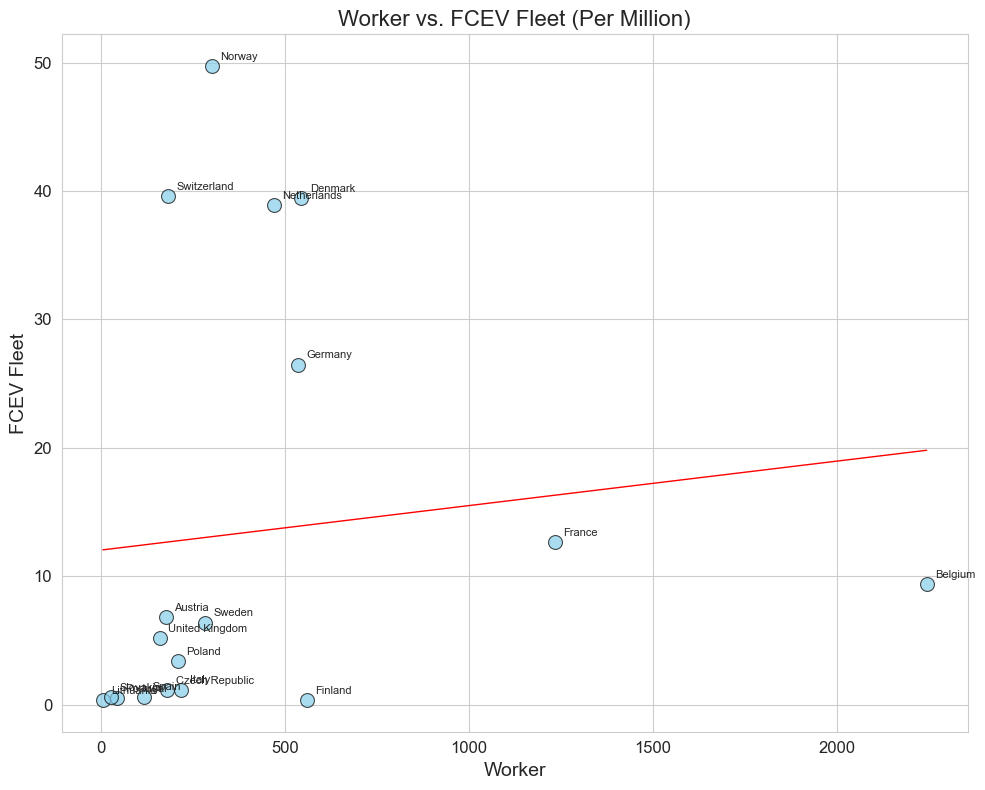

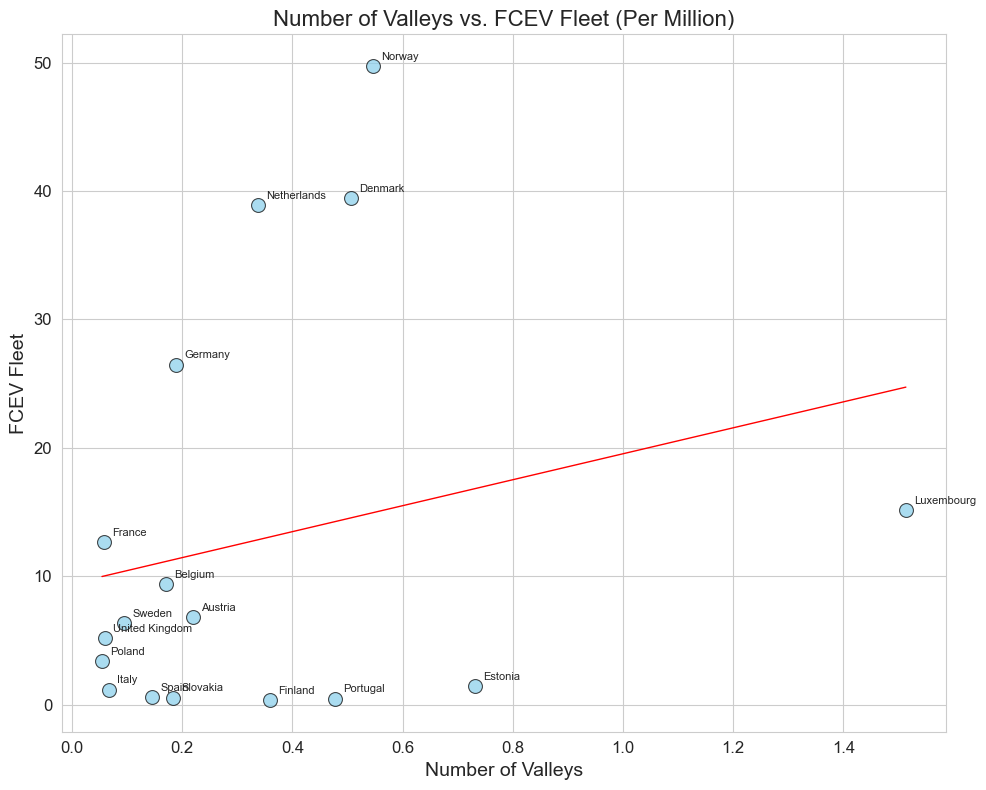

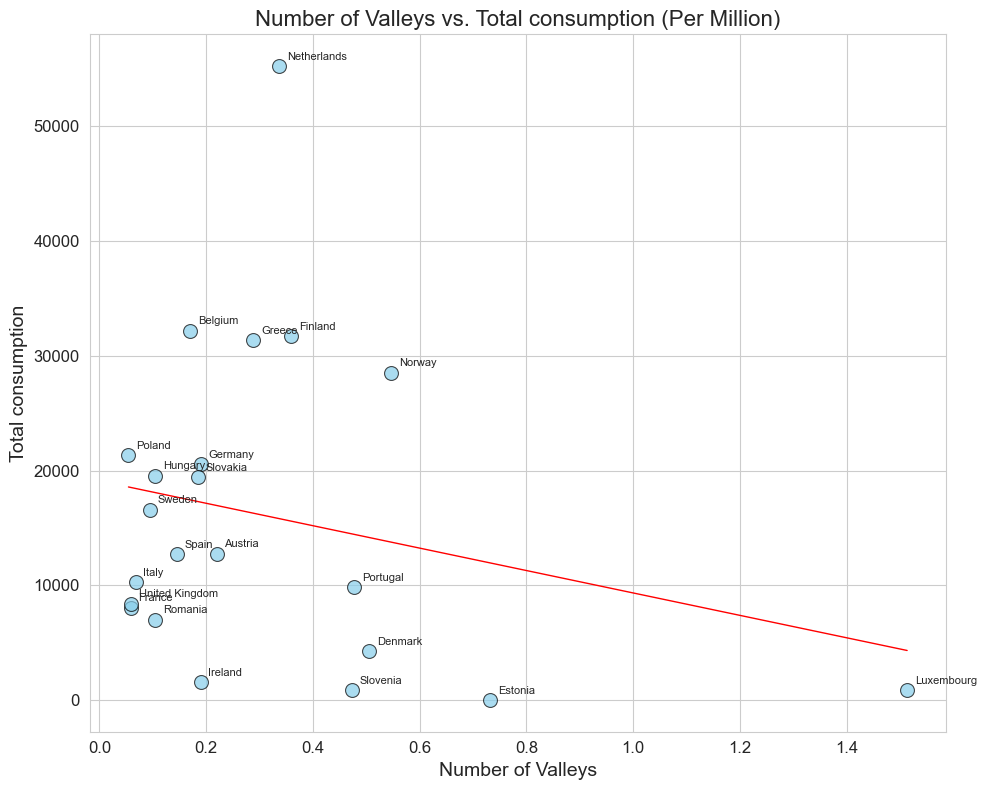

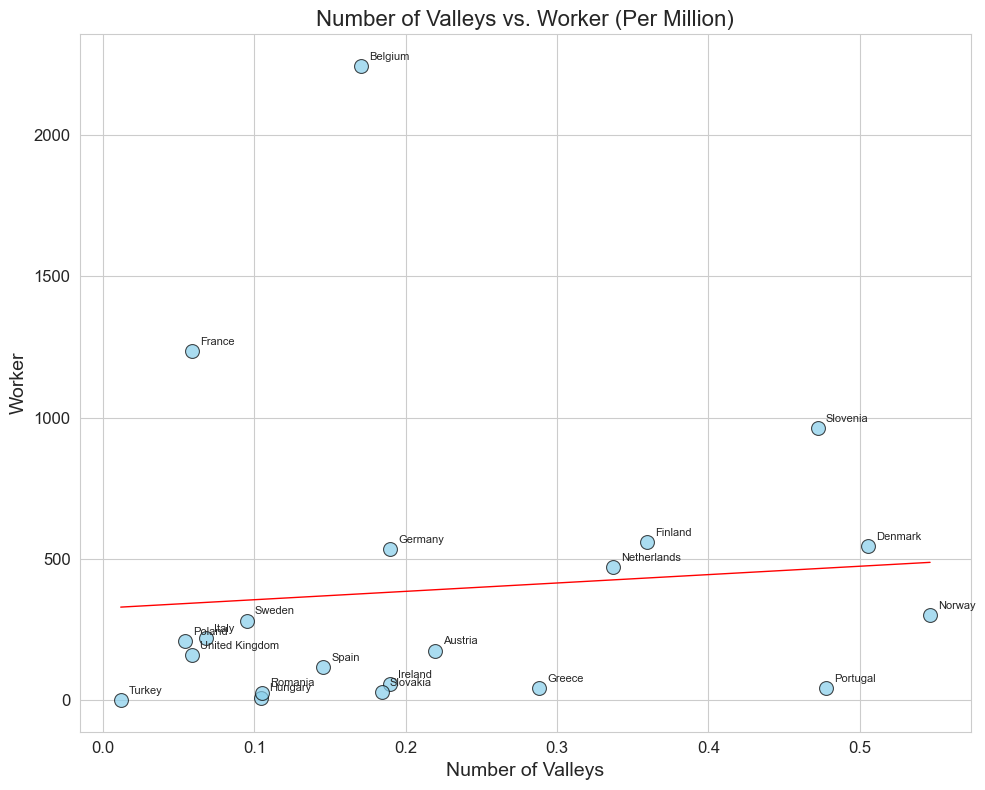

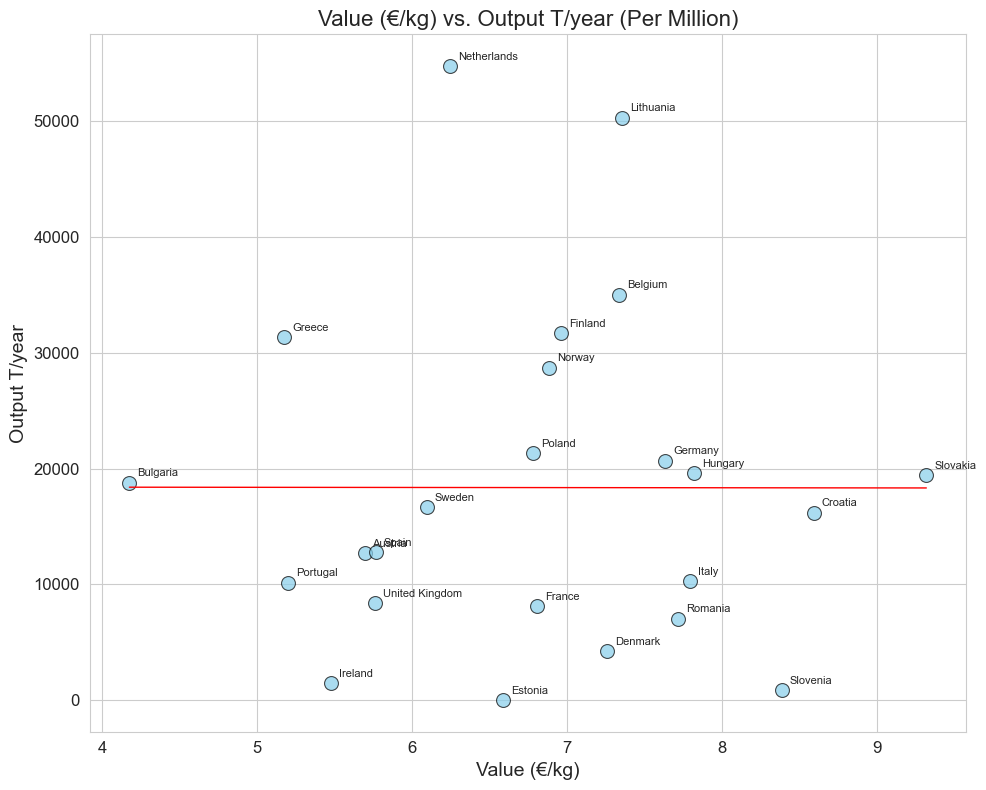

In [84]:
def create_correlation_plots(dataframe, var_pairs, title_suffix=""):
    for x_var, y_var in var_pairs:
        # Filter out rows with zero values in either x_var or y_var
        filtered_df = dataframe[(dataframe[x_var] != 0.0) & (dataframe[y_var] != 0.0)]

        plt.figure(figsize=(10, 8))
        sns.set_style("whitegrid")  # Set the style
        sns.scatterplot(x=x_var, y=y_var, data=filtered_df, s=100, alpha=0.7, color='skyblue', edgecolor='black')  # Adjust marker size and color
        sns.regplot(x=x_var, y=y_var, data=filtered_df, scatter=False, color='red', ci=None, line_kws={"linewidth": 1})  # Adjust regression line

        # Calculate offset based on data range of filtered data
        x_range = filtered_df[x_var].max() - filtered_df[x_var].min()
        y_range = filtered_df[y_var].max() - filtered_df[y_var].min()
        x_offset = x_range * 0.01
        y_offset = y_range * 0.01

        for i in range(len(filtered_df)):
            plt.text(filtered_df[x_var].iloc[i] + x_offset, filtered_df[y_var].iloc[i] + y_offset, filtered_df['Country'].iloc[i], fontsize=8)  # Adjust label font size

        plt.title(f'{x_var} vs. {y_var} {title_suffix}', fontsize=16)  # Adjust title font size
        plt.xlabel(x_var, fontsize=14)  # Adjust x-axis label font size
        plt.ylabel(y_var, fontsize=14)  # Adjust y-axis label font size
        plt.xticks(fontsize=12)  # Adjust tick label font size
        plt.yticks(fontsize=12)  # Adjust tick label font size
        plt.tight_layout()  # Adjust layout
        plt.show()

# Variable pairs for absolute analysis
absolute_pairs = [
    ('Output T/year', 'Total consumption'), #interesting
    ('Number Stations', 'FCEV Fleet'), #obvious buy maybe good to show for the report
    ('Number of Valleys', 'Number Stations'), #interesting
    ('Number of Valleys', 'Value (€/kg)'), #interesting
    ('Number of Valleys', 'Count Research'), #interesting
    ('Number of Patents', 'Count Research'), #interesting
]

# Variable pairs for per million analysis
per_million_pairs = [
    ('Number of Patents', 'Count Research'),
    ('Number of Valleys', 'FCEV Fleet'), #interesting
    ('Number of Valleys', 'Total consumption'), #interesting
    ('Number of Valleys', 'Worker'), #interesting
    ('Value (€/kg)', 'Output T/year'), #interesting
]

# Create plots for absolute numbers
create_correlation_plots(merged_df, absolute_pairs, title_suffix="(Absolute Numbers)")

# Create plots for per million numbers
create_correlation_plots(per_million_df, per_million_pairs, title_suffix="(Per Million)")


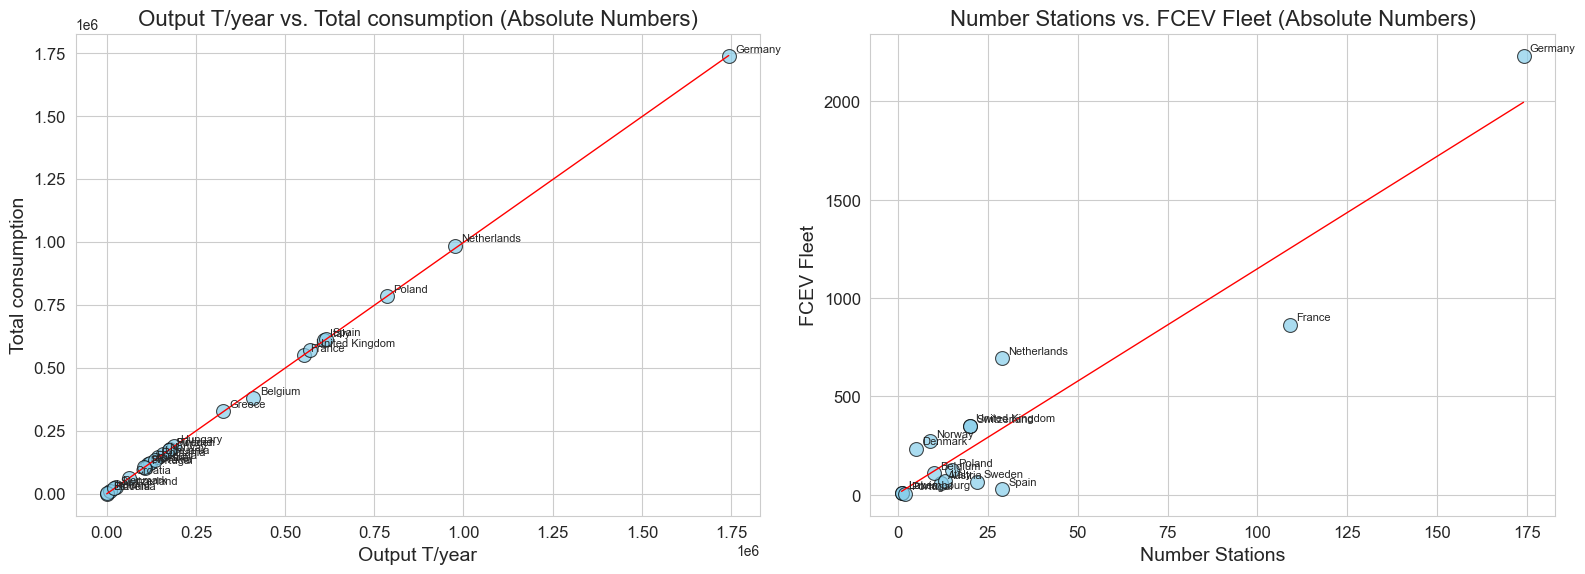

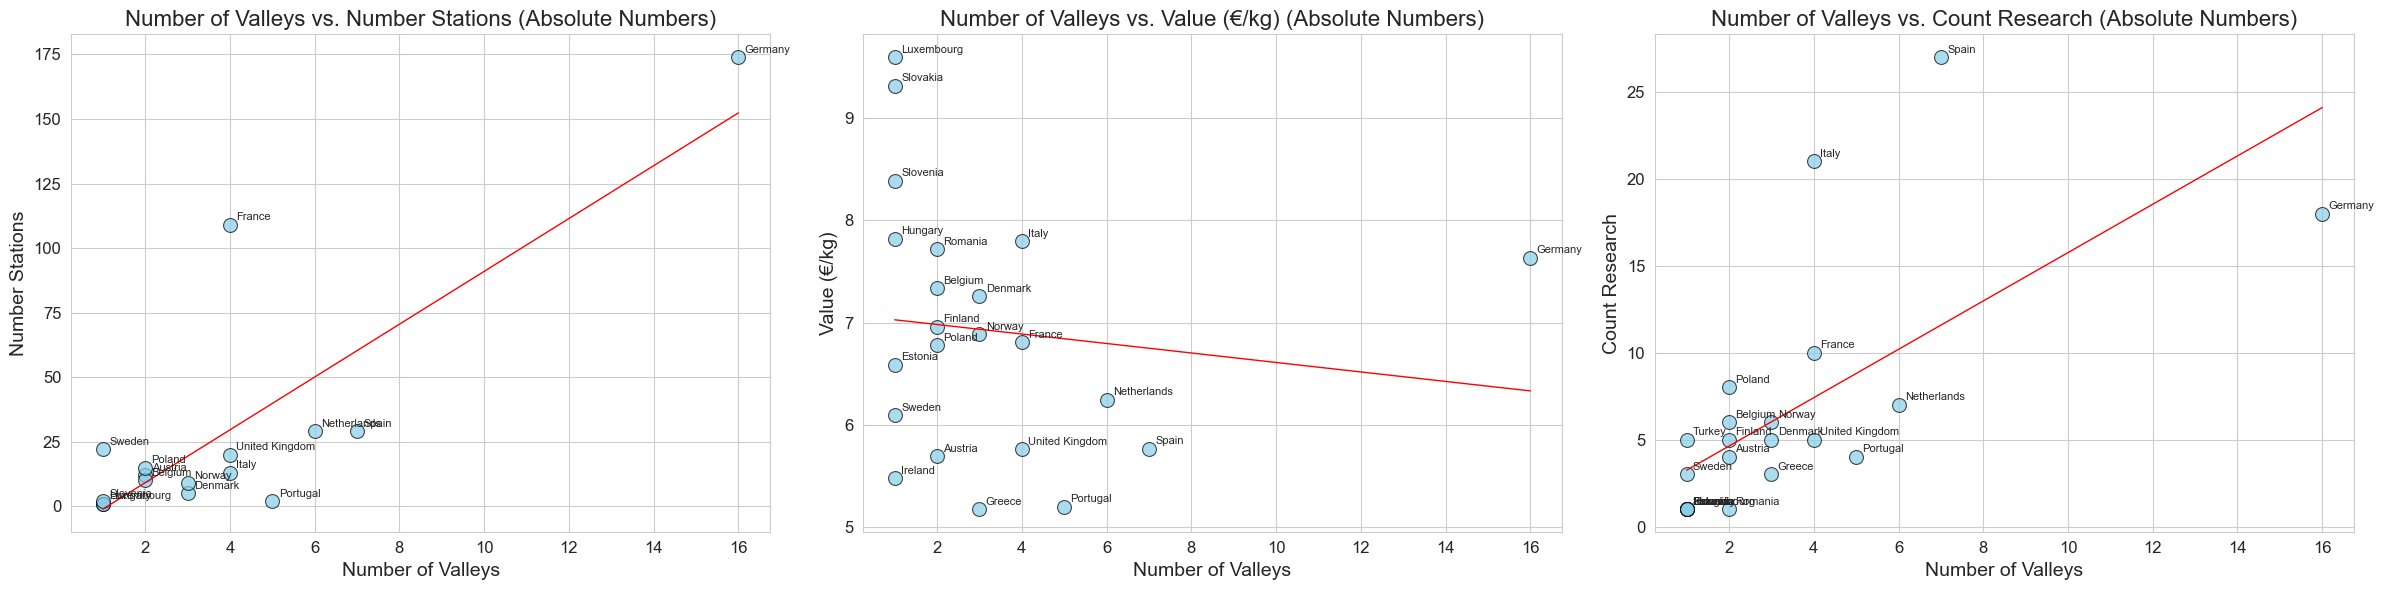

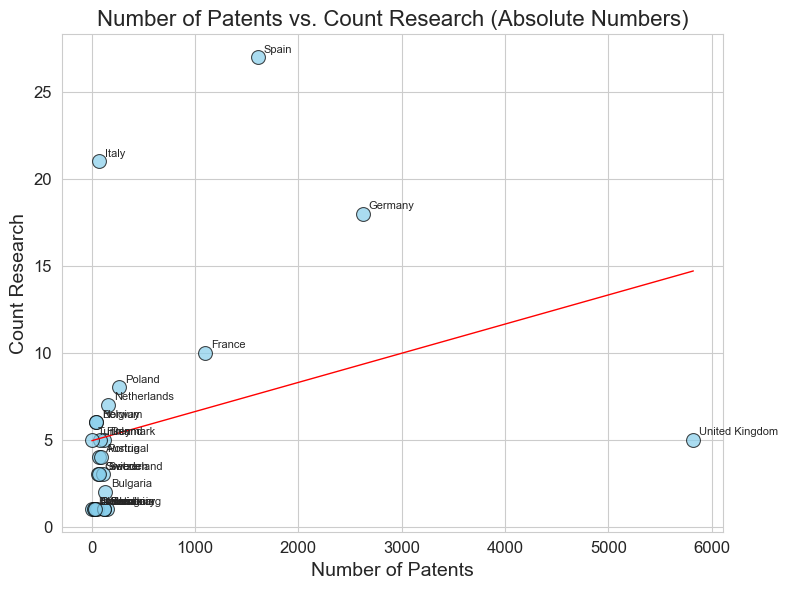

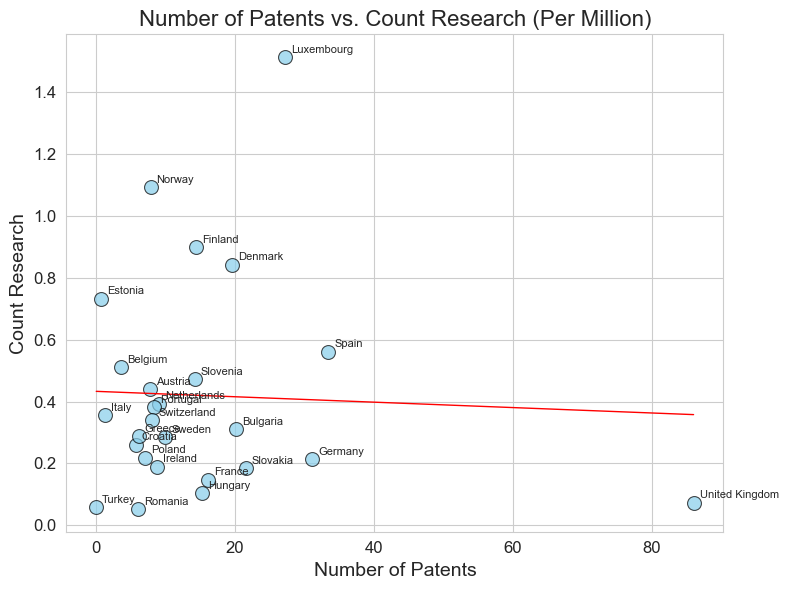

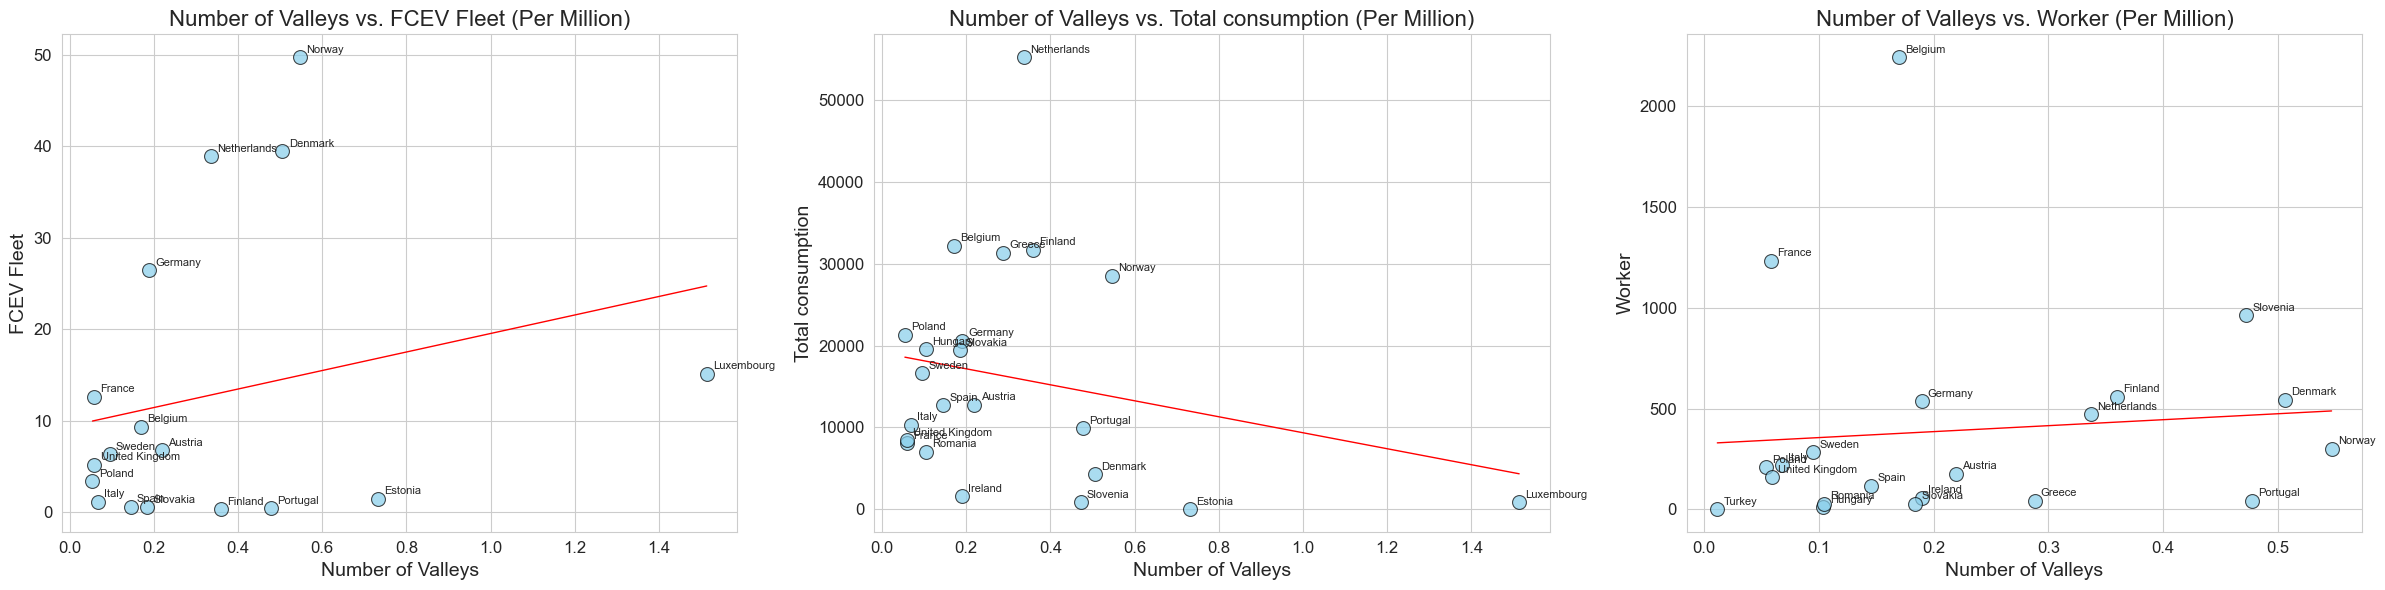

In [99]:
# Define plot combinations
plot_combinations = [
    # Absolute values
    [
        ('Output T/year', 'Total consumption'),
        ('Number Stations', 'FCEV Fleet')
    ],
    [
        ('Number of Valleys', 'Number Stations'),
        ('Number of Valleys', 'Value (€/kg)'),
        ('Number of Valleys', 'Count Research')
    ],
    # Absolute and per million
    [
        ('Number of Patents', 'Count Research'),
        ('Number of Patents', 'Count Research')
    ],
    # Per million values
    [
        ('Number of Valleys', 'FCEV Fleet'),
        ('Number of Valleys', 'Total consumption'),
        ('Number of Valleys', 'Worker')
    ]
]

# Define a function to create and save plots
def create_and_save_plots(dataframe, var_pairs, title_suffix, file_name):
    num_plots = len(var_pairs)
    fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 6))
    axes = np.atleast_1d(axes)  # Ensure axes is always an array

    for i, (x_var, y_var) in enumerate(var_pairs):
        filtered_df = dataframe[(dataframe[x_var] != 0.0) & (dataframe[y_var] != 0.0)]
        
        sns.scatterplot(x=x_var, y=y_var, data=filtered_df, s=100, alpha=0.7, color='skyblue', edgecolor='black', ax=axes[i])
        sns.regplot(x=x_var, y=y_var, data=filtered_df, scatter=False, color='red', ci=None, line_kws={"linewidth": 1}, ax=axes[i])
        
        # Calculate offset based on data range of filtered data
        x_range = filtered_df[x_var].max() - filtered_df[x_var].min()
        y_range = filtered_df[y_var].max() - filtered_df[y_var].min()
        x_offset = x_range * 0.01
        y_offset = y_range * 0.01

        for j in range(len(filtered_df)):
            axes[i].text(filtered_df[x_var].iloc[j] + x_offset, filtered_df[y_var].iloc[j] + y_offset, filtered_df['Country'].iloc[j], fontsize=8)

        axes[i].set_title(f'{x_var} vs. {y_var} {title_suffix}', fontsize=16)
        axes[i].set_xlabel(x_var, fontsize=14)
        axes[i].set_ylabel(y_var, fontsize=14)
        axes[i].tick_params(axis='both', labelsize=12)
    
    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()

# Create plots for absolute numbers - Group 1
create_and_save_plots(merged_df, plot_combinations[0], '(Absolute Numbers)', 'combined_plots_group1.png')

# Create plots for absolute numbers - Group 2
create_and_save_plots(merged_df, plot_combinations[1], '(Absolute Numbers)', 'combined_plots_group2.png')

# Create plots for per million numbers - Group 4
create_and_save_plots(per_million_df, plot_combinations[3], '(Per Million)', 'combined_plots_group4.png')

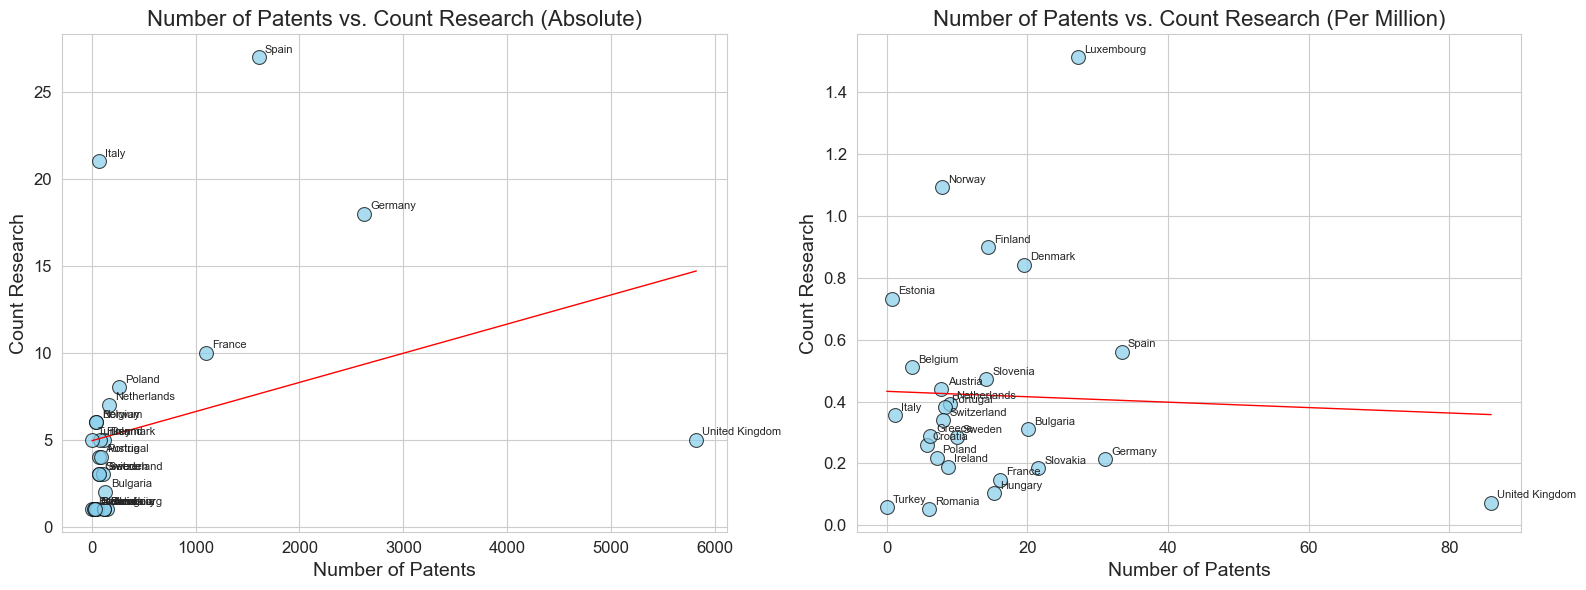

In [100]:
# Define a function to create and save combined plots for absolute and per million values
def create_combined_plots(data_abs, data_per_million, var_pairs_abs, var_pairs_per_million, title_suffix, file_name):
    num_plots = len(var_pairs_abs) + len(var_pairs_per_million)
    fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 6))
    axes = np.atleast_1d(axes)  # Ensure axes is always an array

    for i, (x_var, y_var) in enumerate(var_pairs_abs):
        filtered_df = data_abs[(data_abs[x_var] != 0.0) & (data_abs[y_var] != 0.0)]
        
        sns.scatterplot(x=x_var, y=y_var, data=filtered_df, s=100, alpha=0.7, color='skyblue', edgecolor='black', ax=axes[i])
        sns.regplot(x=x_var, y=y_var, data=filtered_df, scatter=False, color='red', ci=None, line_kws={"linewidth": 1}, ax=axes[i])
        
        # Calculate offset based on data range of filtered data
        x_range = filtered_df[x_var].max() - filtered_df[x_var].min()
        y_range = filtered_df[y_var].max() - filtered_df[y_var].min()
        x_offset = x_range * 0.01
        y_offset = y_range * 0.01

        for j in range(len(filtered_df)):
            axes[i].text(filtered_df[x_var].iloc[j] + x_offset, filtered_df[y_var].iloc[j] + y_offset, filtered_df['Country'].iloc[j], fontsize=8)

        axes[i].set_title(f'{x_var} vs. {y_var} (Absolute)', fontsize=16)
        axes[i].set_xlabel(x_var, fontsize=14)
        axes[i].set_ylabel(y_var, fontsize=14)
        axes[i].tick_params(axis='both', labelsize=12)

    for i, (x_var, y_var) in enumerate(var_pairs_per_million):
        filtered_df = data_per_million[(data_per_million[x_var] != 0.0) & (data_per_million[y_var] != 0.0)]
        
        sns.scatterplot(x=x_var, y=y_var, data=filtered_df, s=100, alpha=0.7, color='skyblue', edgecolor='black', ax=axes[i + len(var_pairs_abs)])
        sns.regplot(x=x_var, y=y_var, data=filtered_df, scatter=False, color='red', ci=None, line_kws={"linewidth": 1}, ax=axes[i + len(var_pairs_abs)])
        
        # Calculate offset based on data range of filtered data
        x_range = filtered_df[x_var].max() - filtered_df[x_var].min()
        y_range = filtered_df[y_var].max() - filtered_df[y_var].min()
        x_offset = x_range * 0.01
        y_offset = y_range * 0.01

        for j in range(len(filtered_df)):
            axes[i + len(var_pairs_abs)].text(filtered_df[x_var].iloc[j] + x_offset, filtered_df[y_var].iloc[j] + y_offset, filtered_df['Country'].iloc[j], fontsize=8)

        axes[i + len(var_pairs_abs)].set_title(f'{x_var} vs. {y_var} (Per Million)', fontsize=16)
        axes[i + len(var_pairs_abs)].set_xlabel(x_var, fontsize=14)
        axes[i + len(var_pairs_abs)].set_ylabel(y_var, fontsize=14)
        axes[i + len(var_pairs_abs)].tick_params(axis='both', labelsize=12)
    
    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()

# Create combined plots for Group 3
create_combined_plots(merged_df, per_million_df, [plot_combinations[2][0]], [plot_combinations[2][1]], '(Absolute and Per Million)', 'combined_plots_group3.png')

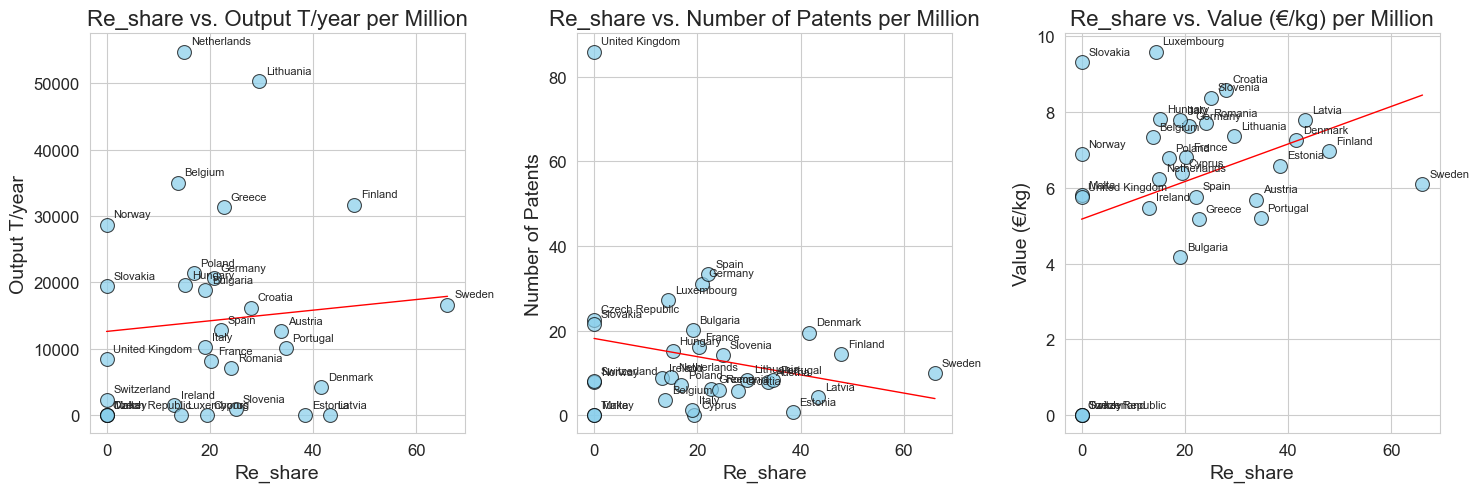

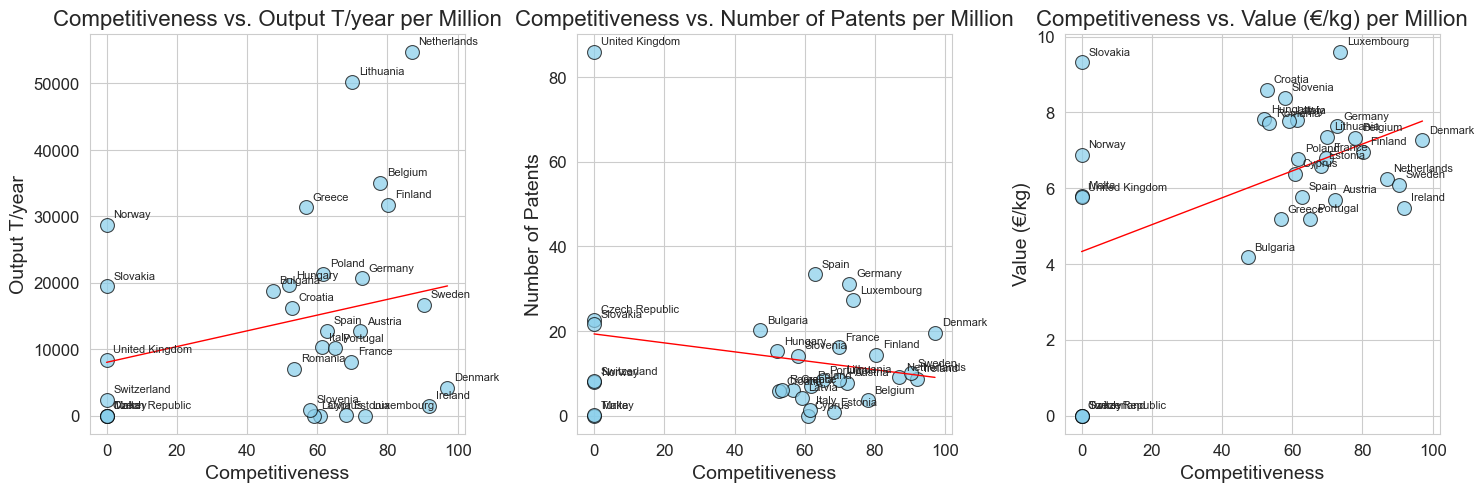

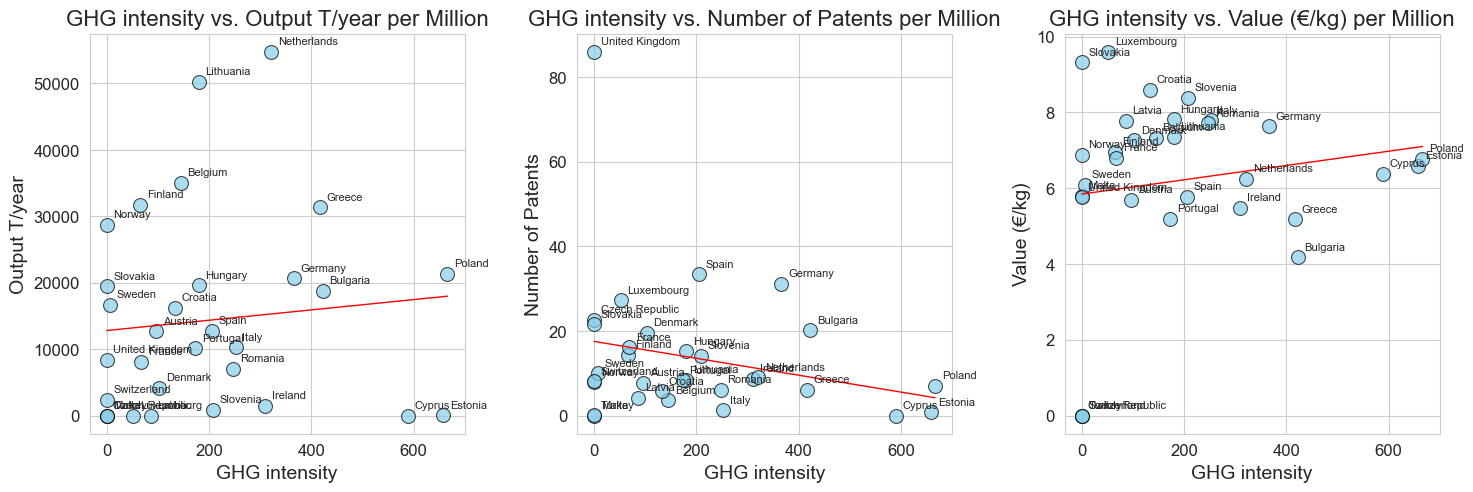

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_index_comparison_plots(dataframe, indices, variables, title_suffix=""):
    for index in indices:
        num_vars = len(variables)
        fig, axes = plt.subplots(1, num_vars, figsize=(5 * num_vars, 5))
        axes = np.atleast_1d(axes)  # Ensure axes is always an array

        for col, var in enumerate(variables):
            ax = axes[col]
            sns.set_style("whitegrid")
            sns.scatterplot(x=index, y=var, data=dataframe, s=100, alpha=0.7, color='skyblue', edgecolor='black', ax=ax)
            sns.regplot(x=index, y=var, data=dataframe, scatter=False, color='red', ci=None, line_kws={"linewidth": 1}, ax=ax)

            x_range = dataframe[index].max() - dataframe[index].min()
            y_range = dataframe[var].max() - dataframe[var].min()
            x_offset = x_range * 0.02
            y_offset = y_range * 0.02

            for i in range(len(dataframe)):
                ax.text(dataframe[index].iloc[i] + x_offset, dataframe[var].iloc[i] + y_offset, dataframe['Country'].iloc[i], fontsize=8)

            ax.set_title(f'{index} vs. {var} {title_suffix}', fontsize=16)
            ax.set_xlabel(index, fontsize=14)
            ax.set_ylabel(var, fontsize=14)
            ax.tick_params(axis='both', labelsize=12)

        plt.tight_layout()
        plt.subplots_adjust(top=0.9, bottom=0.1, left=0.05, right=0.95, hspace=0.3, wspace=0.3)  # Adjust layout to add space between plots
        plt.savefig(f'{index}_comparison_{title_suffix.replace(" ", "_")}.png')
        plt.show()

# Define indices and hydrogen economy variables
indices = ['Re_share', 'Competitiveness', 'GHG intensity']
hydrogen_variables = ['Output T/year', 'Number of Patents', 'Value (€/kg)']

# Create scatter plots with regression lines
create_index_comparison_plots(per_million_df_index, indices, hydrogen_variables, title_suffix="per Million")


In [41]:
# Step 3: Value Chain Analysis
value_chain_steps = {
    'Production': ['Output T/year'],
    'Costs': ['Value (€/kg)'],
    'Demand': ['Total consumption'],
    'Research': ['Count Research'],
    'Patents': ['Number of Patents'],
    'Charging Infrastructure': ['Number Stations'],
    'Usage ': ['FCEV Fleet'],
    'Companies': ['Number of Companies']
}

relative_distribution = {}

for step, columns in value_chain_steps.items():
    relative_distribution[step] = merged_df[columns].sum(axis=1) / merged_df[columns].sum(axis=1).sum()
    print(f'{step}: {relative_distribution[step]}')


Production: 0     0.014208
1     0.050600
2     0.014910
3     0.007668
4     0.000000
5     0.000000
6     0.003070
7     0.000002
8     0.021710
9     0.068023
10    0.214533
11    0.040182
12    0.023133
13    0.000968
14    0.074801
15    0.000000
16    0.017680
17    0.000000
18    0.000000
19    0.119999
20    0.019393
21    0.096547
22    0.013078
23    0.016529
24    0.012993
25    0.000227
26    0.075608
27    0.021578
28    0.002529
29    0.000000
30    0.070030
dtype: float64
Costs: 0     0.029594
1     0.038135
2     0.021712
3     0.044651
4     0.033191
5     0.000000
6     0.037733
7     0.034241
8     0.036185
9     0.035385
10    0.039679
11    0.026911
12    0.040652
13    0.028472
14    0.040507
15    0.040439
16    0.038241
17    0.049879
18    0.030153
19    0.032467
20    0.035784
21    0.035234
22    0.027024
23    0.040107
24    0.048428
25    0.043587
26    0.029979
27    0.031673
28    0.000000
29    0.000000
30    0.029957
dtype: float64
Demand: 0     0.01436

In [42]:
relative_distribution = pd.DataFrame(relative_distribution)
relative_distribution.index = merged_df['Country']
relative_distribution

relative_distribution.sum(axis=0)

Production                 1.0
Costs                      1.0
Demand                     1.0
Research                   1.0
Patents                    1.0
Charging Infrastructure    1.0
Usage                      1.0
Companies                  1.0
dtype: float64

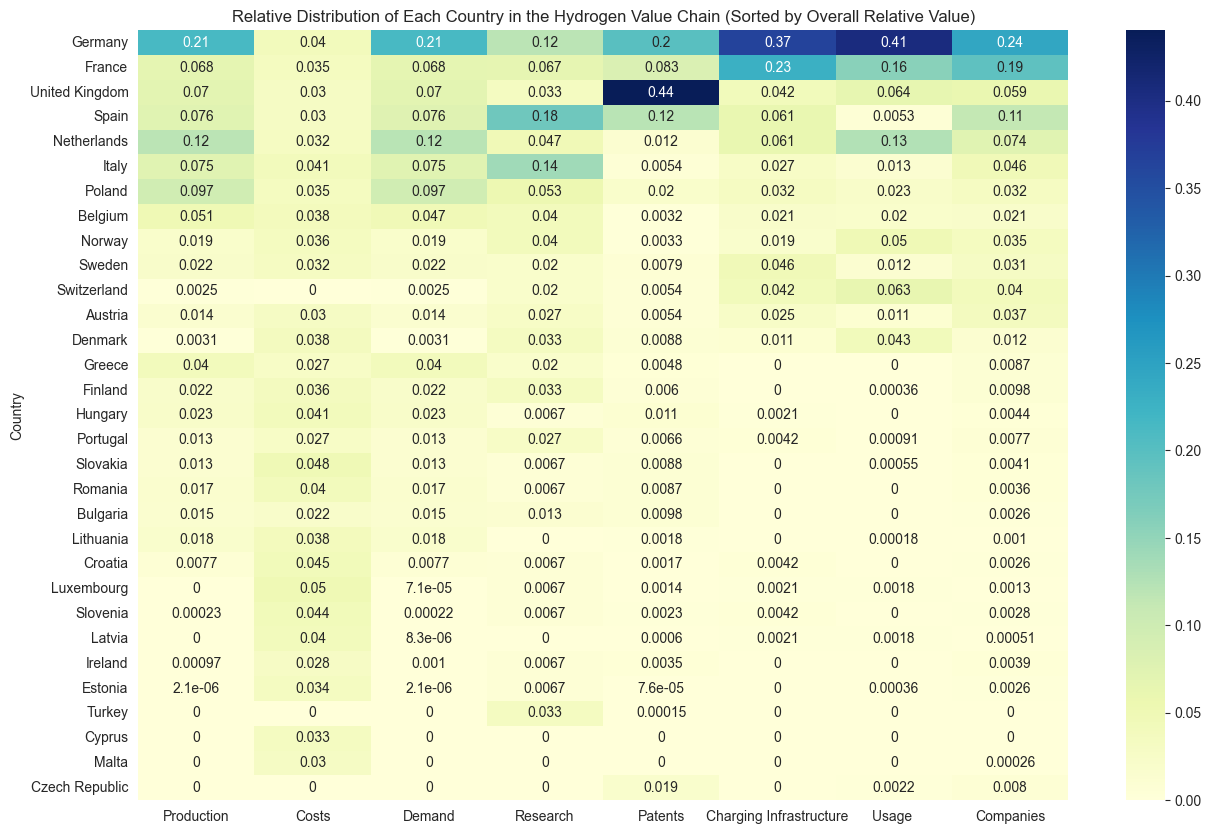

In [43]:
# Calculate the sum of each row
relative_distribution['row_sum'] = relative_distribution.sum(axis=1)

# Sort the DataFrame based on the row sum in descending order
relative_distribution_sorted = relative_distribution.sort_values(by='row_sum', ascending=False).drop(columns='row_sum')

# Plotting heatmap with sorted rows and rotated y-axis tick labels
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(relative_distribution_sorted, cmap='YlGnBu', annot=True, ax=ax)
ax.set_title('Relative Distribution of Each Country in the Hydrogen Value Chain (Sorted by Overall Relative Value)')
plt.yticks(rotation=0)  # Rotate y-axis tick labels to be horizontal
plt.show()

In [18]:
#give plot as png  
fig.savefig('relative_distribution.png')